This notebook uses Gaussian processes to find the distribution of functions that fit a toy dataset, both incorporating correlations between data points and treating each as independent. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from GP import GaussianProcessRegressor

Define some toy data combining multiple perfectly correlated datasets with overlapping energy ranges. x denotes the measured values at each energy, each with some error bar. Each data point has 10% total error. There must be a relatively large number of data points to get a degenerate covariance matrix after the kernel is added -- this is a minimal example of such a dataset. 

In [2]:
datasets = 3
n = 5
N = datasets*n                  # Total number of data points
percent_error = 0.1
x_sets = []                     # x for each dataset
y_sets = []                     # y for each dataset

E = np.zeros(N)                 # All x
x =  np.zeros(N)                # All y

total_errors = np.zeros(N)
systematic_errors = np.zeros(N)
dataset_sizes = np.zeros(datasets)
for i in range(datasets):
    energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
    values = 0.5-np.random.rand(n) + energies                # Provides overall linear relationship with correlated noise
    x_sets.append(energies)
    y_sets.append(values)
    
    s = percent_error*np.abs(values)
    
    for j in range(n):
        index = i*n+j
        E[index] = energies[j]
        x[index] = values[j]
        total_errors[index] = s[j] 
        systematic_errors[index] = s[j]
    dataset_sizes[i] = n


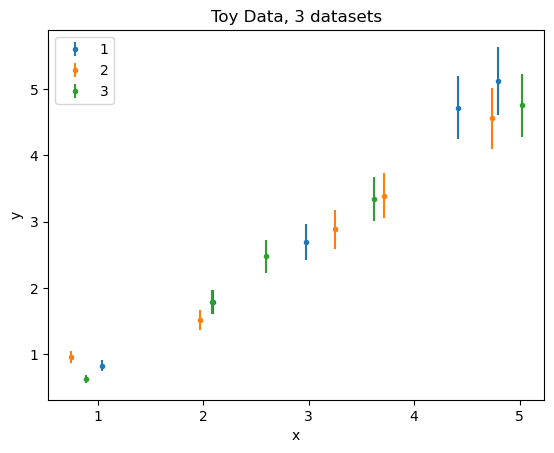

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot the toy data

for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.', label=f'{i+1}')
plt.legend()
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title(f'Toy Data, {datasets} datasets')
plt.show()
plt.clf()

An adapted Gaussian process regression code from scikit-learn that incorporates degeneracies amongst the data is used.

In [4]:
magnitude = 1                             # Initial values for kernel hyperparameters, which get set by extremizing the log-likelihood
length_scale = 1
kernel = ConstantKernel(magnitude) * RBF(length_scale) 
correlated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

correlated_gp, correlated_K11 = correlated_gp.fit(E.reshape(-1,1), x, total_errors, systematic_errors, dataset_sizes)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(E.reshape(-1,1), x, total_errors)

/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/timlaunders/miniconda3/envs/linx/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


While the uncorrelated case produces one large eigenvalue with the rest around 0.1-0.01, the correlated case has an effective rank much lower than the number of columns. (This includes )

In [5]:
print('Uncorrelated GP upper left covariance eigenvalues:\n', eigvals(uncorrelated_K11))
print('\nCorrelated GP upper left covariacnce eigenvalues:\n', eigvals(correlated_K11))

Uncorrelated GP upper left covariance eigenvalues:
 [2.51058335e+02+0.j 1.71663721e+01+0.j 7.52455565e-01+0.j
 5.00927261e-01+0.j 4.63619448e-01+0.j 4.60327715e-01+0.j
 7.09806682e-02+0.j 8.91375239e-02+0.j 3.37137224e-01+0.j
 3.17448127e-01+0.j 2.79786871e-01+0.j 2.56135357e-01+0.j
 1.56845003e-01+0.j 2.00150307e-01+0.j 1.78794019e-01+0.j]

Correlated GP upper left covariacnce eigenvalues:
 [5.95928534e-01+0.00000000e+00j 4.37696496e-01+0.00000000e+00j
 4.34966906e-01+0.00000000e+00j 3.23112673e-05+0.00000000e+00j
 1.00000468e-10+0.00000000e+00j 1.00000066e-10+0.00000000e+00j
 1.00000036e-10+0.00000000e+00j 9.99999724e-11+0.00000000e+00j
 1.00000003e-10+1.01903712e-17j 1.00000003e-10-1.01903712e-17j
 1.00000012e-10+0.00000000e+00j 1.00000008e-10+0.00000000e+00j
 9.99999889e-11+4.59596107e-19j 9.99999889e-11-4.59596107e-19j
 9.99999991e-11+0.00000000e+00j]


In [6]:
# Get GP posterior

num_test = 300
E_test = np.linspace(0.5, n+0.5, num_test)
correlated_mean, correlated_std = correlated_gp.predict(E_test.reshape(-1,1), return_std=True)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(E_test.reshape(-1,1), return_std=True)

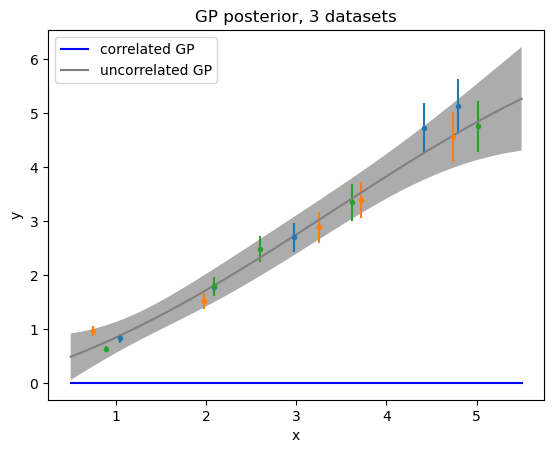

In [7]:
for i in range(datasets):
    plt.errorbar(x_sets[i], y_sets[i], percent_error*np.abs(y_sets[i]), fmt='.')

plt.plot(E_test, correlated_mean, color='blue', label='correlated GP')
plt.fill_between(E_test, correlated_mean - 2*correlated_std, correlated_mean + 2*correlated_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(E_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(E_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'GP posterior, {datasets} datasets')
plt.show()

This analysis is repeated with only 1 correlated dataset.

In [8]:
E = np.zeros(n)
x =  np.zeros(n)
total_errors = np.zeros(n)
systematic_errors = np.zeros(n)
dataset_sizes = np.zeros(datasets)

energies = np.array([j+1 for j in range(n)]) + (0.5-np.random.rand(n))
values = 0.5-np.random.rand(n) + energies

s = percent_error*np.abs(values)

for j in range(n):
    E[j] = energies[j]
    x[j] = values[j]
    total_errors[j] = s[j] 
    systematic_errors[j] = s[j]
dataset_sizes[i] = n

In [9]:
correlated_gp = GaussianProcessRegressor(kernel=kernel)
uncorrelated_gp = GaussianProcessRegressor(kernel=kernel)

correlated_gp, correlated_K11 = correlated_gp.fit(E.reshape(-1,1), x, total_errors, systematic_errors, dataset_sizes)
uncorrelated_gp, uncorrelated_K11 = uncorrelated_gp.fit(E.reshape(-1,1), x, total_errors)

correlated_mean, correlated_std = correlated_gp.predict(E_test.reshape(-1,1), return_std=True)
uncorrelated_mean, uncorrelated_std = uncorrelated_gp.predict(E_test.reshape(-1,1), return_std=True)

In [10]:
print('Uncorrelated GP upper left covariance eigenvalues:\n', eigvals(uncorrelated_K11))
print('\nCorrelated GP upper left covariacnce eigenvalues:\n', eigvals(correlated_K11))

Uncorrelated GP upper left covariance eigenvalues:
 [92.31601154+0.j  7.25899856+0.j  0.56718095+0.j  0.17984026+0.j
  0.3394097 +0.j]

Correlated GP upper left covariacnce eigenvalues:
 [29.54776277+0.j 14.36583531+0.j  5.55424908+0.j  1.1990166 +0.j
  0.10498901+0.j]


The effect is not as pronounced as before (note the eigenvalues have not decayed to near 0 with onyl 5 total data points). However, the correlated case still shows a mean driven below the input data points. Note that since 10% total error is used, the smallest data point has the smallest error. 

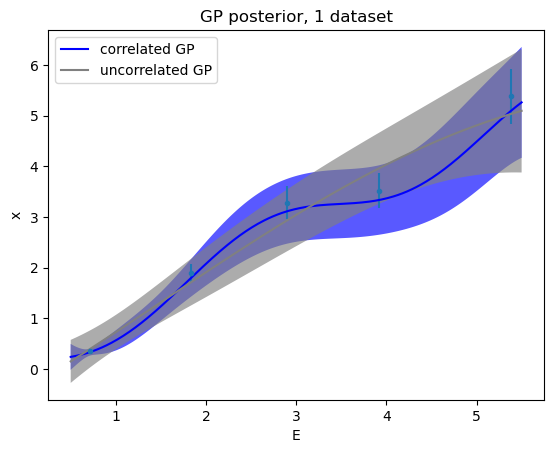

In [11]:
plt.errorbar(E, x, percent_error*np.abs(x), fmt='.')

plt.plot(E_test, correlated_mean, color='blue', label='correlated GP')
plt.fill_between(E_test, correlated_mean - 2*correlated_std, correlated_mean + 2*correlated_std, color='blue', alpha=0.65, edgecolor='none')
plt.plot(E_test, uncorrelated_mean, color='grey', label='uncorrelated GP')
plt.fill_between(E_test, uncorrelated_mean - 2*uncorrelated_std, uncorrelated_mean + 2*uncorrelated_std, color='grey', alpha=0.65, edgecolor='none')
plt.legend()
plt.xlabel('E')
plt.ylabel('x')
plt.title(f'GP posterior, 1 dataset')
plt.show()